# Construct data drift detection method
This notebook contains a prototype method for detecting whether application input data characteristics differ from those of the annotated sets used for training.

The relatively general approach taken consists of the following steps.
1. Choose quantifiable characteristics of samples (e.g. text length or anomaly score) gauged important to the prediction model.
2. Compare live data with validation data, with respect to the chosen characteristics, using a method for quantifiyng similarity between univariate distributions.
3. Set initial thresholds, based on test data, for notifying model maintainers.

## Load data
The below code loads the training data splits as well as some simulated "live" data which problematically contains some spanish documents.

In [1]:
import re
import json

def _load_docs(split):
    with open(f"../data/swedish_sentiment_{split}.jsonl") as f:
        docs = [json.loads(l)["text"] for l in f.read().split("\n") if l]
    return docs

train_docs, val_docs, test_docs = (_load_docs(s) for s in ["train", "val", "test"])
len(train_docs), len(val_docs), len(test_docs)

(100, 50, 50)

In [2]:
live_docs = """träningen var intensiv men känslan efteråt var perfekt
första gången på musik festival, det var magiskt
sanden var varm men det var skönt att springa längst strandkanten ändå
lunchen på nya restaurangen var överraskande utsökt
fika med en gammal klasskamrat var exakt vad jag behövde
första dagen på nya universitetet gick mycket bättre än jag trodde
presentationen tog tid men vi nådde ett resultat
köade fyra timmar för konsertkort och sedan var allt slut
jag blev helt förvånad över hur bra denna artist fortfarande kan prestera live
äntligen hittade jag rätt klänning till festen
föreläsningen var så dålig att jag pluggade själv istället
pizzan kom fel och jag fick invänta rätt beställning
rörtvätten var som vanligt väldigt obehaglig
me enfermé el día anterior a mi cumpleaños qué típico
la comida estuvo bien nada especial pero comible
el pódcast fue entretenido probablemente escucharé de nuevo""".split("\n")

## Choose quantifiable characteristics of text data
To identify drift in text data, we first need to identify quantifiable characteristics of the texts to use.
Here we start simple, with fraction of out-of-training-vocabulary words and text length.
There are many other possibilities here (anomaly detection score, LLM as a classifier, ...).

In [3]:
def clean(text):
    """Strip punctuation and lowercase."""
    return re.sub(r"[^\w\s]", "", text).lower()

train_vocab = set().union(*(clean(d).split() for d in train_docs))

def fraction_out_of_vocab(text):
    """% of words in text that were not present in the training set."""
    return sum(1 for word in clean(text).split() if word not in train_vocab) / len(text.split())

def length(text):
    """Number of words in the text."""
    return len(text.split())

## Compare live data with validation data
Once suitable characteristics are identified, we need a method to quantify how much they differ between sets of data, e.g. between the validation set and a live data set or between the set of texts received the previous month with that of the current month.

Here, we use the Kolmogorov-Smirnov test statistic.
While the invoked routine carries out a hypothesis test and returns a P-value corresponding to the statistic, we choose to focus on the statistic only, as a metric of similarity between the validation set distribution and test or live data distribution.
It is conveniently bounded between 0 and 1 and available in SciPy.

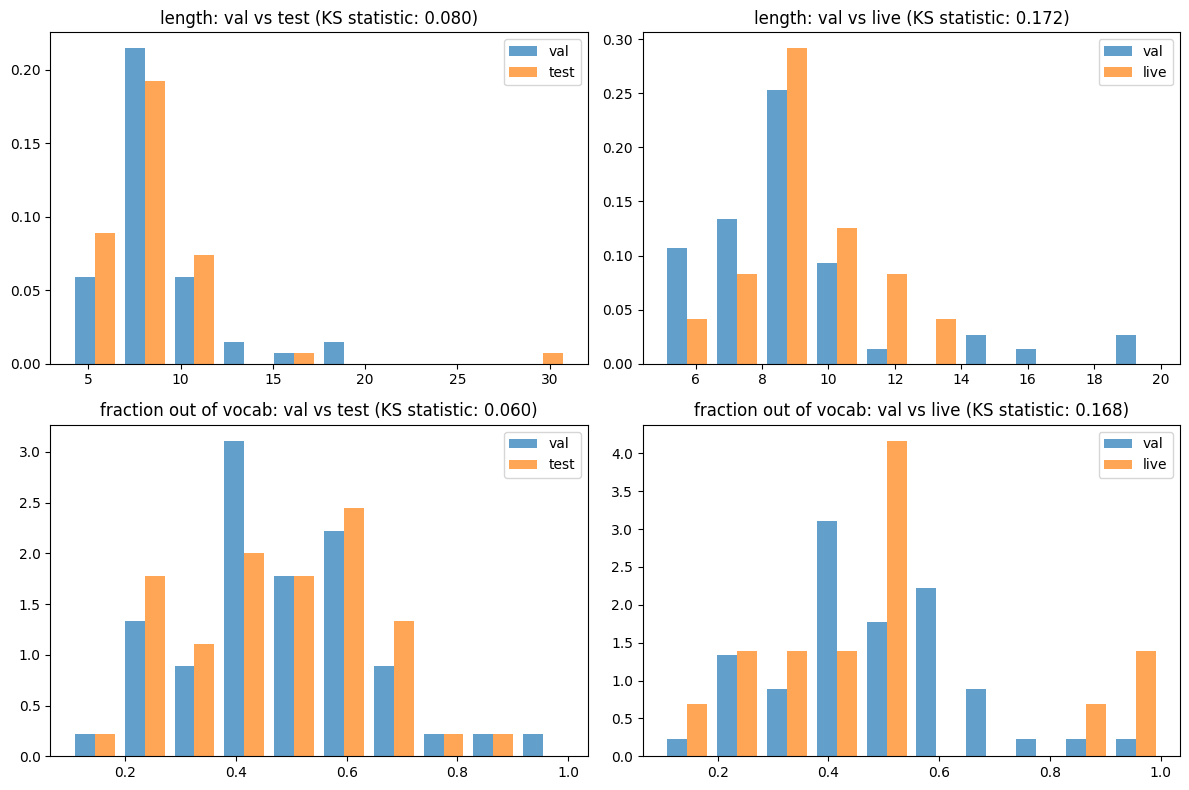

In [4]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, (metric_name, metric, split, docs) in zip(
    axes.flat,
    [
        ("length", length, "test", test_docs),
        ("length", length, "live", live_docs),
        ("fraction out of vocab", fraction_out_of_vocab, "test", test_docs),
        ("fraction out of vocab", fraction_out_of_vocab, "live", live_docs),
    ]
):
    validation_values = [metric(d) for d in val_docs]
    comparison_values = [metric(d) for d in docs]
    ks_statistic = ks_2samp(validation_values, comparison_values).statistic
    
    vmin = min(*validation_values, *comparison_values)
    vmax = max(*validation_values, *comparison_values)
    ax.hist(
        [validation_values, comparison_values],
        alpha=0.7,
        label=["val", split],
        bins=10,
        range=(vmin, vmax),
        density=True,
    )
    ax.set_title(f"{metric_name}: val vs {split} (KS statistic: {ks_statistic:.3f})")
    ax.legend()

plt.tight_layout()

## Interpreting the plots and choosing initial notification thresholds
The histograms compare simulated "live" data and test data with validation data.
We see that the live data, with known problems, exhibits greater visual difference as well as larger KS statistic, with respect to the validation set, than the test set.

This result indicates that the perceived drift detection method is useful.
The test set KS statistics serve as initial notification thresholds.
When live statistics are smaller, we trust that the live data is similar enough to the validation data, which we have thoroughly annotateted and measured model performance on.
When live statistics are larger, we may suspect drift and consider retraining the model with newly annotated data.

## Code for deployment
Here is a version of the drift measurement code intended for deployment and a sanity check that it yields the same result as that above.

In [5]:
from models.monitoring import data_drift_scores
data_drift_scores?

Signature:
data_drift_scores(
    train_docs: list[str],
    val_docs: list[str],
    new_docs: list[str],
) -> dict[str, float]
Docstring:
Compute how different the input is compared to the validation set.

The returned scores are computed as the Kolmogorov-Smirnov statistics from two-sided
tests comparing the distributions of text length and out-of-vocabulary word fraction.
File:      ~/model-deployment-starter/models/monitoring.py
Type:      function

In [6]:
data_drift_scores(train_docs, val_docs, live_docs)

{'length': 0.1725, 'fraction_out_of_vocab': 0.1675}